In [3]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In [4]:

# Path to images and labels
IMAGE_PATH = "../CW_Dataset/train/images"
LABEL_PATH = "../CW_Dataset/train/labels"

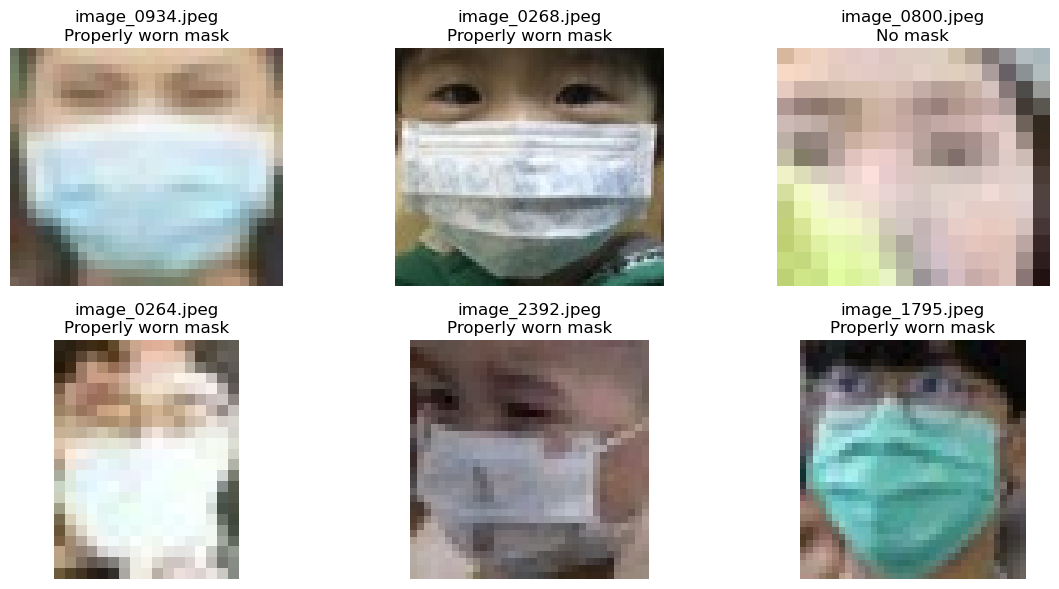

In [5]:
# Map to associate value with category
label_map = {
    '0': "No mask",
    '1': "Properly worn mask",
    '2': "Improperly worn mask"
}

# Get all images
image_files = [f for f in os.listdir(IMAGE_PATH) if f.lower().endswith('.jpeg')]

# Select random images
num_samples = 6
sampled_images = random.sample(image_files, num_samples)

# Plot
plt.figure(figsize=(12, 6))
for i, img_name in enumerate(sampled_images):
    img_path = os.path.join(IMAGE_PATH, img_name)

    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB for matplotlib

    # Find label for image
    label_filename = os.path.splitext(img_name)[0] + '.txt'
    label_path = os.path.join(LABEL_PATH, label_filename)

    # Read label
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label_index = f.read().strip()
        label_text = label_map.get(label_index, "Unknown label")
    else:
        label_text = 'Unknown label'

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"{img_name}\n{label_text}")
    plt.axis('off')

plt.tight_layout()
plt.show()


- Initially thought of using padding to make all images the same size
- Realised this might cause issues with edge detection, because of the sharp border of the black/white pixels I will be adding
	- This could cause big issues down the line with feature descriptors
- Thought about adding padding then using a pre-trained face detection model to crop into the faces and pull a consistent size
- Realised, if I'm using face detection, then why bother adding padding as the face detection should only pull the face regardless of image size.
- Options
	- OpenCV Haar Cascade Classifier
	- OpenCV DNN Face Detection
	- dlib.get_frontal_face()
- Decided on using OpenCVs DNN Face Detection model
- Learnt that that model needs images of at least 100x100 to be nicely accurate
- Realised, that due to the vast different in the sizes of the images even if the image size wasn't an issue, the face detection model would probably poorly handle up/downscaling of the images

- Going to write code to allow me to find the frequency of the sizes of the images and visualise them, that way I can choose the best size to normalise too. I.e.
	- Most images are in the range 10x10 - 70x70 then 64x64 seems fitting
	- Most images are in the range 100x100 - 150x150 then 128x128 seems fitting

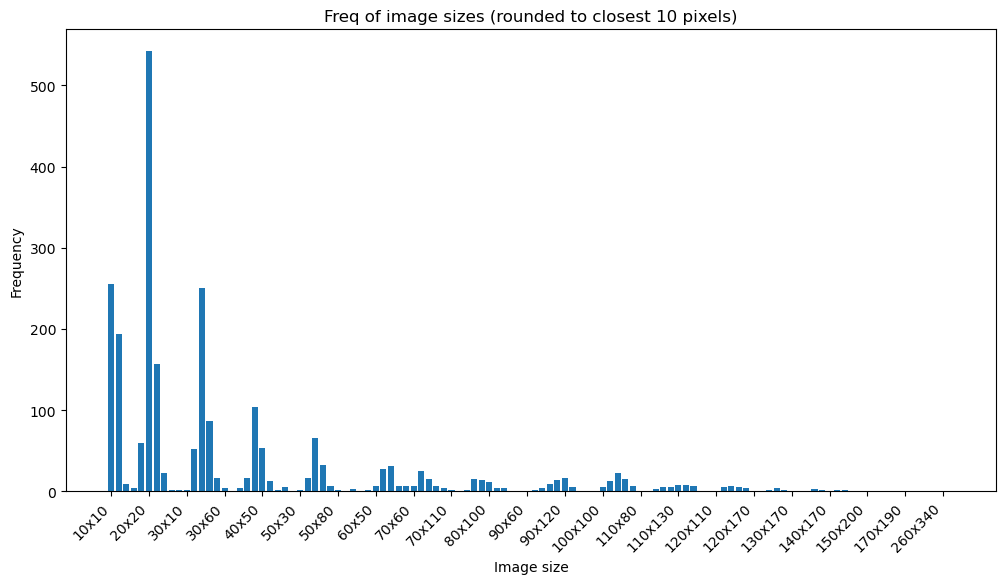

In [9]:
image_sizes = []

for filename in os.listdir(IMAGE_PATH):
    if filename.lower().endswith('.jpeg'):
        img_path = os.path.join(IMAGE_PATH, filename)
        img = cv2.imread(img_path)

        if img is not None:
            h, w = img.shape[:2]
            rounded_sizes = (w // 10 * 10, h // 10 * 10)
            image_sizes.append(rounded_sizes)

counter = Counter(image_sizes)

sorted_sizes = sorted(counter.items(), key=lambda x: (x[0][0], x[0][1]))
labels = [f"{w}x{h}" for (w, h), _ in sorted_sizes]
counts = [count for _, count in sorted_sizes]

skip = 5

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xticks(ticks = range(0, len(labels), skip), labels = labels[::skip], rotation = 45, ha = 'right')
plt.title('Freq of image sizes (rounded to closest 10 pixels)')
plt.xlabel('Image size')
plt.ylabel('Frequency')
#plt.tight_layout()
plt.show()


- Based on the results from the visualisation I can see that most of the images are on the smaller side therefore I will go 64x64.
	- I questioned whether I should choose a rectangular size rather than square but upon research learned that
	    - 64x64 is somewhat of a standard
	    - It is best for model compatibility
	    - Allows for uniform cell layout for HOG descriptors
	    - can easily augment the image (flip/rotate)
	    - etc.